In [36]:
import scipy.special
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload 
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from Corrfunc.utils import check_runtime_env

In [38]:
import os.path
import numpy as np
import pandas as pd
import h5py as h5
# parser.add_argument('boxsize') #L
# parser.add_argument('bin_file')
# parser.add_argument('mock_file1')
# parser.add_argument('mock_file2')
# parser.add_argument('output_file')
# parser.add_argument('--siglnMc') #scatter between intrinsic 
# parser.add_argument('--nc') #cluster number density
# parser.add_argument('--zphot') #photo-z
# parser.add_argument('--Qsel') #assembly bias term 
# parser.add_argument('--delg') #R_delta
# parser.add_argument('--downsample_flag')

In [39]:
check_runtime_env()

<ipython-input-40-761f299786ce>:2: RuntimeWarning: divide by zero encountered in log
  return 0.5*(1+scipy.special.erf(np.log(M)/0.6))


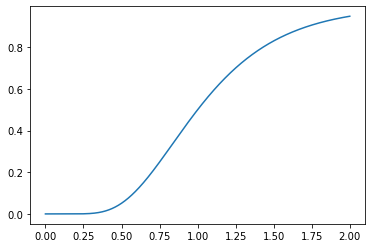

In [40]:
def N_cen(M):
    return 0.5*(1+scipy.special.erf(np.log(M)/0.6))

x = np.linspace(0,2,1000)
y = N_cen(x)

plt.plot(x,y)

The mean satellite number is defined by 
$<N_{sat}(M)> = <N_{cen}(M)> (\frac{M-M_0}{M_1})^{\alpha}$

which has a power-law shape. 

# Calculate Observed Halo Mass 

From Salcedo et al. 2020. 
The cluster-mass observable relation is a linear relation with a constant lognormal scatter:

$\ln M_{obs} = \ln M_c + \sigma_{\ln M_c} X $

The minimal mass for a halo to host a central is $\log M_{min} = \log M_{min,0} + Q_{env}(R_{\delta} - 0.5)$, in which $Q_{env}$ is the environmental dependence of galaxy occupation parameter. $R_\delta$ is the rank of halo environmental density measured with top-hat spheres of radius $8 h^{-1} \text{Mpc}$

# Halo occupation model

The occupation number of the halos is parametrized by 

$<N_{cen}(M)> = \frac{1}{2} [1+\text{erf} (\frac{\log M - \log M_{min}} {\sigma_{\log M}})] $

whose shape can be plotted as the following

# Calculate $\xi$

In [41]:
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"
particle_rel_path = "abacus/particles_subsample.hdf5" 
galaxy_rel_path = "abacus/memHOD_11.2_12.4_0.65_1.0_0.2_0.0_0_z0p3.hdf5"
output_rel_path =  "data/testoutput"
bin_rel_path = "bin_file.txt"

In [42]:
particle_path = os.path.join(project_path, particle_rel_path)
galaxy_path = os.path.join(project_path, galaxy_rel_path)
# halo_path = os.path.join(project_path,halo_rel_path)
output_path = os.path.join(project_path,output_rel_path)
bin_path = os.path.join(project_path,bin_rel_path)

In [43]:
boxsize = 1100
rmin = 0.05
rmax = 125
nbins= 30
bins = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1)
binfile=bin_path
# mock_file1 = halo_path
mock_file2 = particle_path
output_file = output_path
siglnMc = 0.4
nc = 3.228E-6
Qsel = 0
nthreads = 4
zphot = False

In [44]:
print(bins)

[5.00000000e-02 6.48985018e-02 8.42363108e-02 1.09336207e-01
 1.41915121e-01 1.84201575e-01 2.39088125e-01 3.10329222e-01
 4.02798032e-01 5.22819776e-01 6.78604404e-01 8.80808183e-01
 1.14326263e+00 1.48392064e+00 1.92608452e+00 2.50000000e+00
 3.24492509e+00 4.21181554e+00 5.46681037e+00 7.09575606e+00
 9.21007875e+00 1.19544062e+01 1.55164611e+01 2.01399016e+01
 2.61409888e+01 3.39302202e+01 4.40404092e+01 5.71631315e+01
 7.41960319e+01 9.63042262e+01 1.25000000e+02]


In [45]:
import h5py as h5
import os.path
import numpy as np
import math
import Corrfunc
from Corrfunc._countpairs import countpairs

In [46]:
f = open(bin_path,"w")
for i in range(len(bins)-1):
    f.write("{:.2f} {:.2f}\n".format(bins[i],bins[i+1]))
f.close()

In [48]:
# f = h5.File(halo_path, 'r')
# print (type(f.keys()))
# print(type((f)))
# print(type(f['halos']))
# f.close()

In [52]:
import Corrfunc
from Corrfunc.theory.DD import DD

In [53]:
def calculateXi(bins,halo_df,mock_file2,nthreads,boxsize):

    dummy2 = h5.File(str(mock_file2), 'r')
    mock2 = dummy2['particles']
    
    N1 = len(halo_df)
    N2 = len(mock2)
    
    assert N1 != 0
    assert N2 != 0

    x1 = halo_df['pos_x'].to_numpy().astype(np.float32)
    y1 = halo_df['pos_y'].to_numpy().astype(np.float32)
    z1 = halo_df['pos_z'].to_numpy().astype(np.float32)
    
    x2 = mock2['x'].astype(np.float32)
    y2 = mock2['y'].astype(np.float32)
    z2 = mock2['z'].astype(np.float32)
    
        
    input_array = [x1,y1,z1,x2,y2,z2]
    for item in input_array:
        assert type(item) == np.ndarray

    
    results_DD = DD(0, 10, bins, X1=x1, Y1=y1, Z1=z1, X2=x2, Y2=y2, Z2=z2,verbose=True, periodic=True, isa="fastest", boxsize=1100)
    
    for r in results_DD: print("{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f}".format(r['rmin'], r['rmax'], r['ravg'],r['npairs'], r['weightavg'])) # doctest: +NORMALIZE_WHITESPACE

    print(N1, N2, boxsize)
    for i in range(0, len(results_DD)):
        RR = N1*N2*(4.0/3.0)*np.pi*(results_DD[i][1]**3.0 - results_DD[i][0]**3.0) / boxsize**3.0
        print("The value of RR is ", RR)
        results_DD[i][3] =  (results_DD[i][3]/RR - 1.0)
     
    # for r in results_DD: print("{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f}".format(r['rmin'], r['rmax'], r['ravg'],r['npairs'], r['weightavg'])) # doctest: +NORMALIZE_WHITESPACE
    return(results_DD)

In [54]:
halo_df_path=os.path.join(project_path,"data/lambda_spt_combined.pkl")
df = pd.read_pickle(halo_df_path)

In [55]:
projection_depth="30"

In [56]:
d30_mask= (~np.isnan(df[f"lambda_{projection_depth}"])) & (~np.isnan(df['pos_x']))

In [57]:
df_d30=df[d30_mask]

In [58]:
import math

In [59]:
np.sum(df_d30["lambda_30"] >= 60 )

71

In [60]:
modes = ["all","SPT","nonSPT"]
richness_bins=[5,10,14,20,30,45,60,np.inf]

for i in range(len(richness_bins))[-5:-1]:
    lambda_lower, lambda_upper = richness_bins[i],richness_bins[i+1]
    print(lambda_lower, lambda_upper)
    df_richness_mask = (df_d30["lambda_30"] > lambda_lower) & (df_d30['lambda_30'] < lambda_upper)
    df_d30_richness_masked = df_d30[df_richness_mask]
    print(df_d30_richness_masked['lambda_30'].describe())
    
    for mode in modes:
        print(mode)
        if mode == "all":
            df_to_use = df_d30_richness_masked[df_d30_richness_masked['zeta_gt_2']==1]
        elif mode == "SPT":
            df_to_use = df_d30_richness_masked[df_d30_richness_masked["select"]==1]
        elif mode == "nonSPT":
            df_to_use = df_d30_richness_masked[df_d30_richness_masked["select"]==0]
        else: 
            raise

        xi = calculateXi(bins,df_to_use,galaxy_path,10,1100)
        
        print("---------------------------")
        print(xi[:][3])

        output_txt = f"data/result_DD_{lambda_lower}_{mode}_d30.txt"

        outfile = open(os.path.join(project_path,output_txt), 'w')
        print(outfile)
        outfile.write("# rmin rmax xi\n")

        for bin in xi:
            outfile.write(str(bin[0])+" "+str(bin[1])+" "+str(bin[3])+"\n") 

        outfile.close()

20 30
count    14354.000000
mean        23.731921
std          2.381160
min         21.000000
25%         22.000000
50%         23.000000
75%         25.000000
max         29.000000
Name: lambda_30, dtype: float64
all


ND1 =          404 [xmin,ymin,zmin] = [3.573929,4.155802,1.014643], [xmax,ymax,zmax] = [1097.455078,1093.819824,1097.820557]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.140 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.807 secs


  0.050000   0.064899   0.000000         67   0.000000
  0.064899   0.084236   0.000000        113   0.000000
  0.084236   0.109336   0.000000        146   0.000000
  0.109336   0.141915   0.000000        275   0.000000
  0.141915   0.184202   0.000000        364   0.000000
  0.184202   0.239088   0.000000        496   0.000000
  0.239088   0.310329   0.000000        674   0.000000
  0.310329   0.402798   0.000000        890   0.000000
  0.402798   0.522820   0.000000       1164   0.000000
  0.522820   0.678604   0.000000       1316   0.000000
  0.678604   0.880808   0.000000       1698   0.000000
  0.880808   1.143263   0.000000       1875   0.000000
  1.143263   1.483921   0.000000       2217   0.000000
  1.483921   1.926085   0.000000       3629   0.000000
  1.926085   2.500000   0.000000       4495   0.000000
  2.500000   3.244925   0.000000       4989   0.000000
  3.244925   4.211816   0.000000       6969   0.000000
  4.211816   5.466810   0.000000      11208   0.000000
  5.466810

ND1 =          150 [xmin,ymin,zmin] = [4.904932,4.155802,4.439480], [xmax,ymax,zmax] = [1097.455078,1090.665405,1097.820557]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.113 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.315 secs


  0.050000   0.064899   0.000000         24   0.000000
  0.064899   0.084236   0.000000         37   0.000000
  0.084236   0.109336   0.000000         58   0.000000
  0.109336   0.141915   0.000000         91   0.000000
  0.141915   0.184202   0.000000        162   0.000000
  0.184202   0.239088   0.000000        166   0.000000
  0.239088   0.310329   0.000000        220   0.000000
  0.310329   0.402798   0.000000        324   0.000000
  0.402798   0.522820   0.000000        399   0.000000
  0.522820   0.678604   0.000000        492   0.000000
  0.678604   0.880808   0.000000        639   0.000000
  0.880808   1.143263   0.000000        741   0.000000
  1.143263   1.483921   0.000000        879   0.000000
  1.483921   1.926085   0.000000       1267   0.000000
  1.926085   2.500000   0.000000       2014   0.000000
  2.500000   3.244925   0.000000       2081   0.000000
  3.244925   4.211816   0.000000       2713   0.000000
  4.211816   5.466810   0.000000       4566   0.000000
  5.466810

ND1 =        14204 [xmin,ymin,zmin] = [0.111286,0.040574,0.097670], [xmax,ymax,zmax] = [1099.927612,1099.921509,1099.841919]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.001 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.100 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 28.570 secs


  0.050000   0.064899   0.000000       2992   0.000000
  0.064899   0.084236   0.000000       4362   0.000000
  0.084236   0.109336   0.000000       5822   0.000000
  0.109336   0.141915   0.000000       8360   0.000000
  0.141915   0.184202   0.000000      10863   0.000000
  0.184202   0.239088   0.000000      14116   0.000000
  0.239088   0.310329   0.000000      17668   0.000000
  0.310329   0.402798   0.000000      21217   0.000000
  0.402798   0.522820   0.000000      25605   0.000000
  0.522820   0.678604   0.000000      30215   0.000000
  0.678604   0.880808   0.000000      35515   0.000000
  0.880808   1.143263   0.000000      38983   0.000000
  1.143263   1.483921   0.000000      46478   0.000000
  1.483921   1.926085   0.000000      58169   0.000000
  1.926085   2.500000   0.000000      74565   0.000000
  2.500000   3.244925   0.000000     108426   0.000000
  3.244925   4.211816   0.000000     168052   0.000000
  4.211816   5.466810   0.000000     269200   0.000000
  5.466810

ND1 =          259 [xmin,ymin,zmin] = [4.223823,5.310084,0.124862], [xmax,ymax,zmax] = [1091.829712,1099.614990,1099.538574]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.097 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.523 secs


  0.050000   0.064899   0.000000         50   0.000000
  0.064899   0.084236   0.000000         74   0.000000
  0.084236   0.109336   0.000000        127   0.000000
  0.109336   0.141915   0.000000        182   0.000000
  0.141915   0.184202   0.000000        254   0.000000
  0.184202   0.239088   0.000000        414   0.000000
  0.239088   0.310329   0.000000        525   0.000000
  0.310329   0.402798   0.000000        744   0.000000
  0.402798   0.522820   0.000000        924   0.000000
  0.522820   0.678604   0.000000       1109   0.000000
  0.678604   0.880808   0.000000       1304   0.000000
  0.880808   1.143263   0.000000       1488   0.000000
  1.143263   1.483921   0.000000       1808   0.000000
  1.483921   1.926085   0.000000       2400   0.000000
  1.926085   2.500000   0.000000       3556   0.000000
  2.500000   3.244925   0.000000       4031   0.000000
  3.244925   4.211816   0.000000       5012   0.000000
  4.211816   5.466810   0.000000       7622   0.000000
  5.466810

ND1 =          111 [xmin,ymin,zmin] = [4.223823,30.964775,0.124862], [xmax,ymax,zmax] = [1091.829712,1099.614990,1099.538574]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.088 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.256 secs


  0.050000   0.064899   0.000000         21   0.000000
  0.064899   0.084236   0.000000         28   0.000000
  0.084236   0.109336   0.000000         43   0.000000
  0.109336   0.141915   0.000000         83   0.000000
  0.141915   0.184202   0.000000        106   0.000000
  0.184202   0.239088   0.000000        163   0.000000
  0.239088   0.310329   0.000000        232   0.000000
  0.310329   0.402798   0.000000        340   0.000000
  0.402798   0.522820   0.000000        417   0.000000
  0.522820   0.678604   0.000000        483   0.000000
  0.678604   0.880808   0.000000        582   0.000000
  0.880808   1.143263   0.000000        664   0.000000
  1.143263   1.483921   0.000000        838   0.000000
  1.483921   1.926085   0.000000        998   0.000000
  1.926085   2.500000   0.000000       1736   0.000000
  2.500000   3.244925   0.000000       2120   0.000000
  3.244925   4.211816   0.000000       2353   0.000000
  4.211816   5.466810   0.000000       3667   0.000000
  5.466810

ND1 =         2562 [xmin,ymin,zmin] = [0.598797,0.090084,0.056943], [xmax,ymax,zmax] = [1099.474609,1099.907837,1099.840454]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.110 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  5.101 secs


  0.050000   0.064899   0.000000        544   0.000000
  0.064899   0.084236   0.000000        832   0.000000
  0.084236   0.109336   0.000000       1278   0.000000
  0.109336   0.141915   0.000000       1684   0.000000
  0.141915   0.184202   0.000000       2190   0.000000
  0.184202   0.239088   0.000000       3120   0.000000
  0.239088   0.310329   0.000000       3912   0.000000
  0.310329   0.402798   0.000000       4939   0.000000
  0.402798   0.522820   0.000000       5793   0.000000
  0.522820   0.678604   0.000000       7116   0.000000
  0.678604   0.880808   0.000000       8343   0.000000
  0.880808   1.143263   0.000000       9537   0.000000
  1.143263   1.483921   0.000000      11608   0.000000
  1.483921   1.926085   0.000000      15046   0.000000
  1.926085   2.500000   0.000000      18249   0.000000
  2.500000   3.244925   0.000000      24353   0.000000
  3.244925   4.211816   0.000000      36928   0.000000
  4.211816   5.466810   0.000000      57099   0.000000
  5.466810

ND1 =           56 [xmin,ymin,zmin] = [44.843597,53.423672,13.212649], [xmax,ymax,zmax] = [1071.183228,1072.442139,1072.848755]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.119 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.164 secs


  0.050000   0.064899   0.000000         11   0.000000
  0.064899   0.084236   0.000000         21   0.000000
  0.084236   0.109336   0.000000         35   0.000000
  0.109336   0.141915   0.000000         45   0.000000
  0.141915   0.184202   0.000000         53   0.000000
  0.184202   0.239088   0.000000         87   0.000000
  0.239088   0.310329   0.000000        137   0.000000
  0.310329   0.402798   0.000000        180   0.000000
  0.402798   0.522820   0.000000        213   0.000000
  0.522820   0.678604   0.000000        288   0.000000
  0.678604   0.880808   0.000000        339   0.000000
  0.880808   1.143263   0.000000        390   0.000000
  1.143263   1.483921   0.000000        449   0.000000
  1.483921   1.926085   0.000000        542   0.000000
  1.926085   2.500000   0.000000        856   0.000000
  2.500000   3.244925   0.000000       1041   0.000000
  3.244925   4.211816   0.000000       1315   0.000000
  4.211816   5.466810   0.000000       1720   0.000000
  5.466810

ND1 =           33 [xmin,ymin,zmin] = [87.459854,53.423672,13.212649], [xmax,ymax,zmax] = [1071.183228,1072.442139,1015.957886]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.084 secs


  0.050000   0.064899   0.000000          4   0.000000
  0.064899   0.084236   0.000000         13   0.000000
  0.084236   0.109336   0.000000         26   0.000000
  0.109336   0.141915   0.000000         22   0.000000
  0.141915   0.184202   0.000000         23   0.000000
  0.184202   0.239088   0.000000         55   0.000000
  0.239088   0.310329   0.000000         79   0.000000
  0.310329   0.402798   0.000000        117   0.000000
  0.402798   0.522820   0.000000        135   0.000000
  0.522820   0.678604   0.000000        193   0.000000
  0.678604   0.880808   0.000000        217   0.000000
  0.880808   1.143263   0.000000        273   0.000000
  1.143263   1.483921   0.000000        309   0.000000
  1.483921   1.926085   0.000000        336   0.000000
  1.926085   2.500000   0.000000        567   0.000000
  2.500000   3.244925   0.000000        673   0.000000
  3.244925   4.211816   0.000000        861   0.000000
  4.211816   5.466810   0.000000       1091   0.000000
  5.466810

ND1 =          269 [xmin,ymin,zmin] = [13.890323,3.963098,4.092882], [xmax,ymax,zmax] = [1095.980835,1094.688477,1096.161743]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.105 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.551 secs


  0.050000   0.064899   0.000000         67   0.000000
  0.064899   0.084236   0.000000         92   0.000000
  0.084236   0.109336   0.000000        121   0.000000
  0.109336   0.141915   0.000000        176   0.000000
  0.141915   0.184202   0.000000        286   0.000000
  0.184202   0.239088   0.000000        303   0.000000
  0.239088   0.310329   0.000000        396   0.000000
  0.310329   0.402798   0.000000        548   0.000000
  0.402798   0.522820   0.000000        695   0.000000
  0.522820   0.678604   0.000000        804   0.000000
  0.678604   0.880808   0.000000       1028   0.000000
  0.880808   1.143263   0.000000       1122   0.000000
  1.143263   1.483921   0.000000       1476   0.000000
  1.483921   1.926085   0.000000       2036   0.000000
  1.926085   2.500000   0.000000       2466   0.000000
  2.500000   3.244925   0.000000       3005   0.000000
  3.244925   4.211816   0.000000       4129   0.000000
  4.211816   5.466810   0.000000       6339   0.000000
  5.466810

ND1 =           18 [xmin,ymin,zmin] = [39.042103,47.143677,2.513159], [xmax,ymax,zmax] = [1017.470947,953.315002,1096.332275]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.068 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


  0.050000   0.064899   0.000000          4   0.000000
  0.064899   0.084236   0.000000          6   0.000000
  0.084236   0.109336   0.000000          7   0.000000
  0.109336   0.141915   0.000000         15   0.000000
  0.141915   0.184202   0.000000         26   0.000000
  0.184202   0.239088   0.000000         30   0.000000
  0.239088   0.310329   0.000000         39   0.000000
  0.310329   0.402798   0.000000         52   0.000000
  0.402798   0.522820   0.000000         76   0.000000
  0.522820   0.678604   0.000000         81   0.000000
  0.678604   0.880808   0.000000        139   0.000000
  0.880808   1.143263   0.000000        143   0.000000
  1.143263   1.483921   0.000000        127   0.000000
  1.483921   1.926085   0.000000        180   0.000000
  1.926085   2.500000   0.000000        299   0.000000
  2.500000   3.244925   0.000000        307   0.000000
  3.244925   4.211816   0.000000        346   0.000000
  4.211816   5.466810   0.000000        599   0.000000
  5.466810

ND1 =            6 [xmin,ymin,zmin] = [39.042103,227.412338,2.513159], [xmax,ymax,zmax] = [1017.470947,576.711792,754.795654]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.062 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.032 secs


  0.050000   0.064899   0.000000          4   0.000000
  0.064899   0.084236   0.000000          2   0.000000
  0.084236   0.109336   0.000000          3   0.000000
  0.109336   0.141915   0.000000          6   0.000000
  0.141915   0.184202   0.000000          6   0.000000
  0.184202   0.239088   0.000000          9   0.000000
  0.239088   0.310329   0.000000         12   0.000000
  0.310329   0.402798   0.000000         25   0.000000
  0.402798   0.522820   0.000000         31   0.000000
  0.522820   0.678604   0.000000         27   0.000000
  0.678604   0.880808   0.000000         54   0.000000
  0.880808   1.143263   0.000000         53   0.000000
  1.143263   1.483921   0.000000         39   0.000000
  1.483921   1.926085   0.000000         71   0.000000
  1.926085   2.500000   0.000000        122   0.000000
  2.500000   3.244925   0.000000        122   0.000000
  3.244925   4.211816   0.000000        111   0.000000
  4.211816   5.466810   0.000000        199   0.000000
  5.466810

ND1 =           61 [xmin,ymin,zmin] = [15.081444,47.143677,4.043571], [xmax,ymax,zmax] = [1099.429443,1098.228760,1096.332275]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   2.348 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.161 secs


  0.050000   0.064899   0.000000         12   0.000000
  0.064899   0.084236   0.000000         27   0.000000
  0.084236   0.109336   0.000000         25   0.000000
  0.109336   0.141915   0.000000         44   0.000000
  0.141915   0.184202   0.000000         58   0.000000
  0.184202   0.239088   0.000000         92   0.000000
  0.239088   0.310329   0.000000         95   0.000000
  0.310329   0.402798   0.000000        143   0.000000
  0.402798   0.522820   0.000000        195   0.000000
  0.522820   0.678604   0.000000        213   0.000000
  0.678604   0.880808   0.000000        288   0.000000
  0.880808   1.143263   0.000000        300   0.000000
  1.143263   1.483921   0.000000        449   0.000000
  1.483921   1.926085   0.000000        621   0.000000
  1.926085   2.500000   0.000000        788   0.000000
  2.500000   3.244925   0.000000        766   0.000000
  3.244925   4.211816   0.000000       1111   0.000000
  4.211816   5.466810   0.000000       1731   0.000000
  5.466810

In [ ]:
results_path = os.path.join(project_path,"data/results.npz")
np.savez(results_path,results_DD)

In [ ]:
from __future__ import print_function
import numpy as np
from os.path import dirname, abspath, join as pjoin
import Corrfunc
from Corrfunc.theory.DD import DD
binfile = pjoin(dirname(abspath(Corrfunc.__file__)),"../theory/tests/", "bins")
N = 10000
boxsize = 420.0
nthreads = 4
autocorr = 1
seed = 42
np.random.seed(seed)
X = np.random.uniform(0, boxsize, N)
Y = np.random.uniform(0, boxsize, N)
Z = np.random.uniform(0, boxsize, N)
weights = np.ones_like(X)
results = DD(autocorr, nthreads, binfile, X, Y, Z, weights1=weights,
             weight_type='pair_product', output_ravg=True,
             boxsize=boxsize, periodic=True,verbose=True)
for r in results: print("{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f}".
                        format(r['rmin'], r['rmax'], r['ravg'],
                               r['npairs'], r['weightavg'])) # doctest: +NORMALIZE_WHITESPACE

In [ ]:
help(DD)